In [1]:
import utils
from utils import *
import importlib
importlib.reload(utils)

<module 'utils' from 'D:\\gatech\\ML\\unsupervised_learning\\utils.py'>

In [46]:
def load_data(clean=False):
    data_directory = "data/"
    filename = "diabetes.csv"
    df = pd.read_csv(data_directory + filename)
    if clean:
        df = df[df['SkinThickness'] > 0]
        df = df[df['Insulin'] > 0]
    #plt.show()
    cols = list(df.columns.values)
    cols.remove('Outcome')
    X = (df[cols]).values
    y = df['Outcome'].values
    if clean:
        X = StandardScaler().fit_transform(X)
    return(X, y)

def split_data(X, y, data_size=1.0, train_size=0.8, strat=False):
    if strat:
        sss = StratifiedShuffleSplit(n_splits=1, random_state=0, train_size=train_size, test_size=train_size/4)
        for train_index, test_index in sss.split(X, y):
            print("hm")
            X_train = X[train_index]
            X_test = X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=train_size/4)
    return(X_train, y_train, X_test, y_test)

def k_means_elbow_viz(X, k_range=(2, 15)):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=k_range)
    visualizer.fit(X)
    visualizer.show()

def k_means_silhouette(X, range_n_clusters =[2, 3, 4, 5, 6, 7, 8, 9, 10]):


    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()


def GMM_elbow(X, y, range_n_clusters=[1, 2, 3, 4, 5, 6]):
    aics = []
    bics = []
    scores = []
    for i in range_n_clusters:
        gmm = GMM(random_state=13, n_components=i)
        gmm.fit(X)
        aics.append(gmm.aic(X))
        bics.append(gmm.bic(X))
        scores.append(gmm.score(X, y))
    plt.plot(range_n_clusters, aics, label="AIC")
    plt.plot(range_n_clusters, bics, label="BIC")
    plt.xlabel ("n clusters")
    plt.ylabel ("AIC/BIC")
    plt.legend()
    plt.title ("AIC/BIC elbow method per n_clusters")
    plt.show()



def build_pc_col_names(num):
    col_vals = []
    for i in range(1, num+1):
        col_vals.append(i)
    return col_vals

def compare_comp_vals_PCA(X, y, vals_range=[1, 2, 3, 4, 5, 6, 7]):
    result_dfs = []
    n_comp_vals = vals_range
    for comp_val in n_comp_vals:
        print("uh")
        pca = PCA(n_components=comp_val)
        col_vals = build_pc_col_names(comp_val)
        components = pca.fit_transform(X)

        pdf = pd.DataFrame(data = components
                     , columns = col_vals)
        pdy = pd.DataFrame(data=y, columns=["labels"])
        finalDf = pd.concat([pdf, pdy], axis = 1)
        result_dfs.append(finalDf)

        variance_ratio = pd.DataFrame({'var':pca.explained_variance_ratio_,
                     'PC':col_vals})
        sns.barplot(x='PC',y="var", data=variance_ratio, color="c");
        plt.show()
        plt.clf()
    return result_dfs

def pca_experiment(X, y, n_components, variance_thresh, visualize=True):
    pca = PCA(n_components=n_components)
    col_vals = build_pc_col_names(n_components)
    components = pca.fit_transform(X)
    print(X.shape)
    print(components.shape)

    pdf = pd.DataFrame(data = components
                 , columns = col_vals)
    pdy = pd.DataFrame(data=y, columns=["labels"])
    finalDf = pd.concat([pdf, pdy], axis = 1)
    variance_ratio = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':col_vals})
    if visualize:
        sns.barplot(x='PC',y="var", data=variance_ratio, color="c");
        plt.show()
        plt.clf()
    cumsum = 0
    last_col_to_keep = 0
    for i in range(n_components):
        print(variance_ratio['var'][i])
        if cumsum < variance_thresh:
            print("yes")
            cumsum += variance_ratio['var'][i]
            last_col_to_keep = i
    print(components.shape)
    components_to_keep = components[:, :last_col_to_keep]
    print(components_to_keep.shape)
    return(components_to_keep)

def analyze_ICA(X, n_components, visualize=True):
    rec_err = []
    avg_kurts = []
    best_kurt = -9999
    best_n_comp_val = 0
    maxComponents = 8
    minComponents = 1
    for i in range(1, n_components):
        ica = FastICA(n_components=i)
        ica.fit(X)
        rec_err.append(reconstructionError(ica,X))
        kurt = np.average(kurtosis(ica.components_))
        avg_kurts.append(kurt)
        if kurt > best_kurt:
            best_kurt = kurt
            best_n_comp_val = i
    if visualize:
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, n_components),
                 avg_kurts,
                 'bo',
                 range(1, n_components),avg_kurts,'k')
        plt.xlabel('Number of Components')
        plt.ylabel('Average Kurtosis')
        plt.title('ICA - Kurtosis by Number of Components')
        plt.tight_layout()
        plt.show()


        plt.figure(figsize=(6, 4))
        plt.plot(range(1, n_components),
                 rec_err,
                 'bo',
                 range(1, n_components),
                 rec_err,
                 'k')
        plt.xlabel('# Components')
        plt.ylabel('Rec err')
        plt.title('ICA  err for # Components')
        plt.tight_layout()
        plt.show()
    return best_n_comp_val, best_kurt
  

def ica_experiment(X, n_comps, visualize=True):
    columns_na = []
    for i in range(1, n_comps + 1):
        columns_na.append("ic " + str(i))
    transformer = FastICA(n_components=n_comps, random_state=0)
    X_transformed = transformer.fit_transform(X)
    X_transformed.shape
    pdf = pd.DataFrame(data = X_transformed, columns = columns_na)
    pdy = pd.DataFrame(data=y, columns=['labels'])
    icaDf = pd.concat([pdf, pdy], axis = 1)
    if visualize:
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1)
        ax.set_xlabel('ic 1', fontsize = 15)
        ax.set_ylabel('ic 2', fontsize = 15)
        ax.set_title('ICA', fontsize = 20)
        targets = [0, 1]
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            points_in_label = icaDf['labels'] == target
            ax.scatter(icaDf.loc[points_in_label, 'ic 1']
                       , icaDf.loc[points_in_label, 'ic 2']
                       , c = color
                       , s = 50)
        ax.legend(targets)
        ax.grid()

        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('ic 1', fontsize = 15)
        ax.set_ylabel('ic 2', fontsize = 15)
        ax.set_zlabel('ic 3', fontsize = 15)
        ax.set_title('ICA', fontsize = 20)
        targets = [0, 1]
        colors = ['g', 'r']
        for target, color in zip(targets,colors):
            points_in_label = icaDf['labels'] == target
            ax.scatter(icaDf.loc[points_in_label, 'ic 1']
                       , icaDf.loc[points_in_label, 'ic 2']
                       , icaDf.loc[points_in_label, 'ic 3']
                       , c = color
                       , s = 50)
        ax.legend(targets)
        #ax.set_ylim(-1, 1)
        ax.grid()

    return icaDf

def run_PCA(X,y,title):

    pca = PCA(random_state=5).fit(X) #for all components
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-')
    ax1.set_xlabel('Principal Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'm-')
    ax2.set_ylabel('Eigenvalues', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("PCA Explained Variance and Eigenvalues: "+ title)
    fig.tight_layout()
    plt.show()

def run_ICA(X,y,title): #when kurtosis high, components less gaussian, more independent

    dims = list(np.arange(2,(X.shape[1]-1),3))
    #dims = list(np.arange(2,80,3))
    dims.append(X.shape[1])
    ica = FastICA(random_state=5)
    kurt = []

    for dim in dims:
        print(dim)
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

def run_SparseRandomProjection(X,title):

    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)
    for i,dim in product(range(5),dims):
        rp = SparseRandomProjection(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()

def RP_experiment(X, n_comps, visualize=True):
    rp = SparseRandomProjection(n_components=n_comps)
    X_new = rp.fit_transform(X)
    return(X_new)

def RFC_experiment(X, y, columns, x_indices, threshold=0.8, visualize=True):
    print(X)
    X_copy = X.copy()
    rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
    rnd_clf.fit(X, y)
    zipped = zip(df.columns[:-1], rnd_clf.feature_importances_)
    for name, importance in zipped:
        print(name, "=", importance)
    zipped = list(zip(df.columns[:-1], rnd_clf.feature_importances_))
    print(zipped)
    res = sorted(zipped, key = lambda x: x[1], reverse=True)
    print(res)

    indices = np.argsort(rnd_clf.feature_importances_)
    print(indices)

    cumsum = 0
    useful_cols = []
    useful_indices = []
    i = 0
    while cumsum < threshold:
        cumsum += res[i][1]
        useful_cols.append(res[i][0])
        i+=1

    for column, idx in zip(df.columns[:-1], x_indices):
        if column in useful_cols:
            useful_indices.append(idx)
    print("hm ",useful_indices)
    print(X_copy.shape)
    X_copy = X_copy[:, useful_indices]
    print(X_copy.shape)
    if visualize:
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), rnd_clf.feature_importances_[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [df.columns[:-1][i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
    return(X_copy)



def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]

    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)


In [22]:
X, y = load_data(clean=True)

# K MEANS

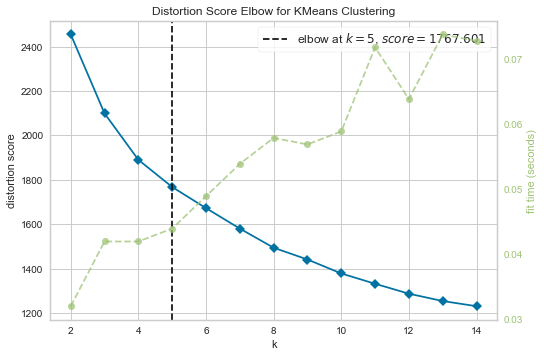

In [23]:
k_means_elbow_viz(X)

For n_clusters = 2 The average silhouette_score is : 0.2398460639116155
For n_clusters = 3 The average silhouette_score is : 0.21038601796366543
For n_clusters = 4 The average silhouette_score is : 0.2031293662011789
For n_clusters = 5 The average silhouette_score is : 0.15467168998367087
For n_clusters = 6 The average silhouette_score is : 0.15092385134030312
For n_clusters = 7 The average silhouette_score is : 0.1676753107386964
For n_clusters = 8 The average silhouette_score is : 0.16105709212562488
For n_clusters = 9 The average silhouette_score is : 0.14459146288339755
For n_clusters = 10 The average silhouette_score is : 0.14031787808047672


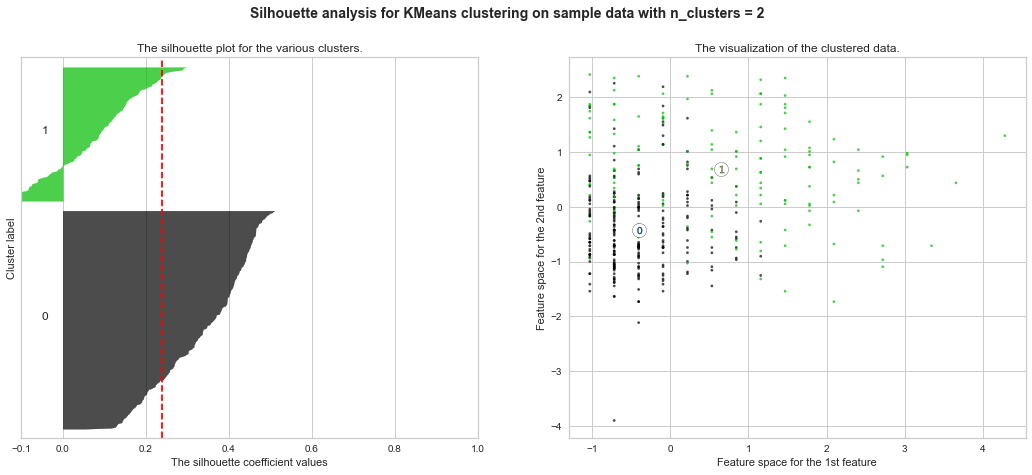

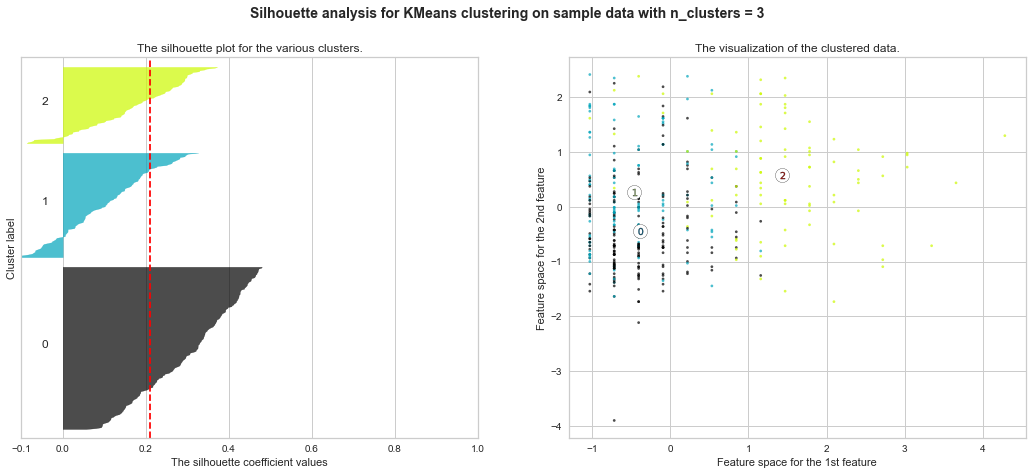

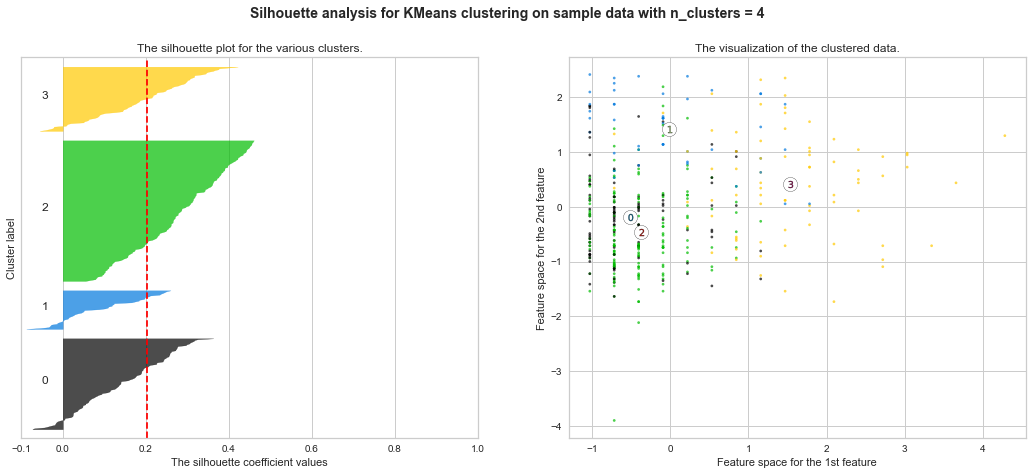

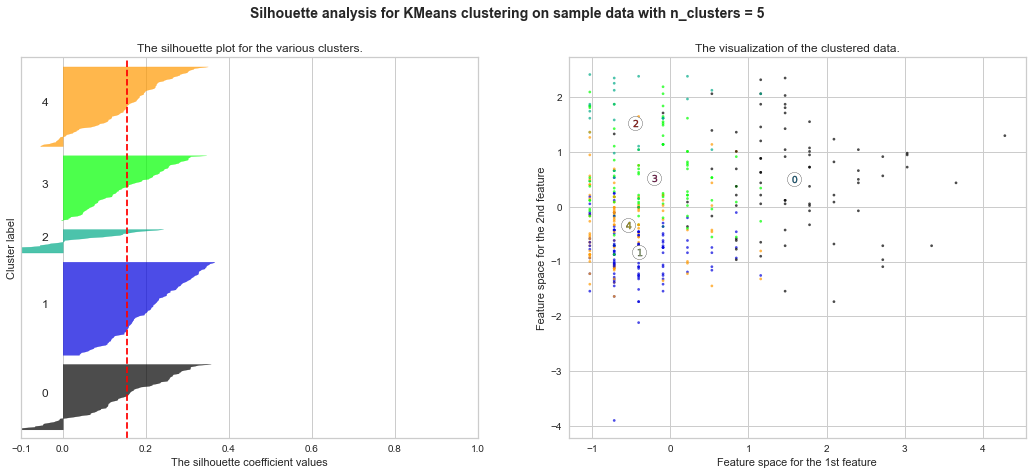

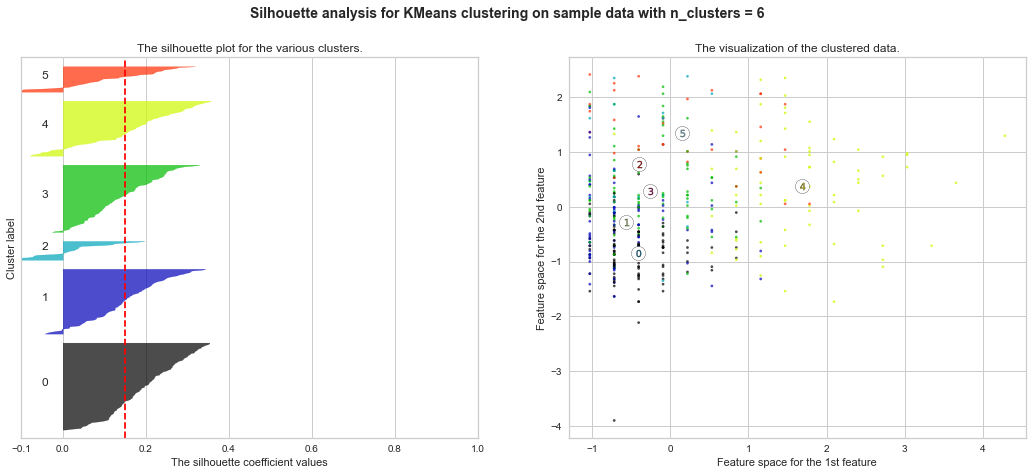

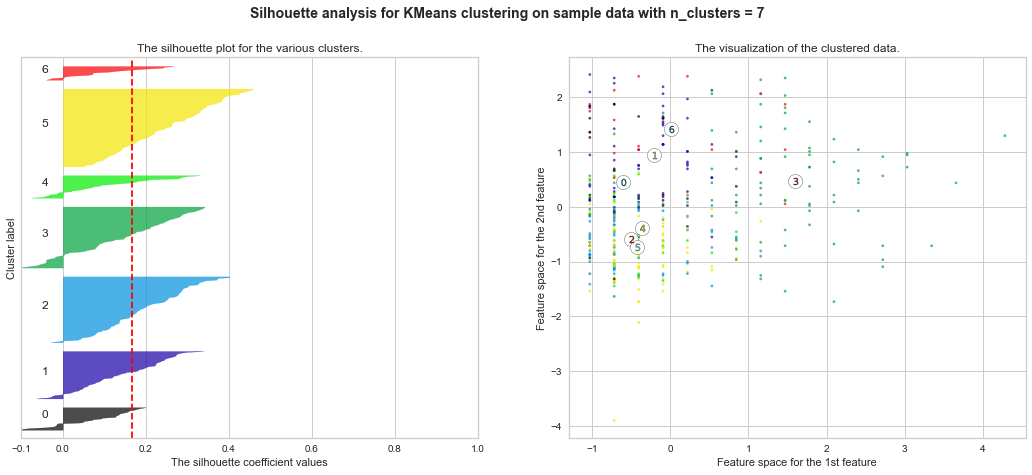

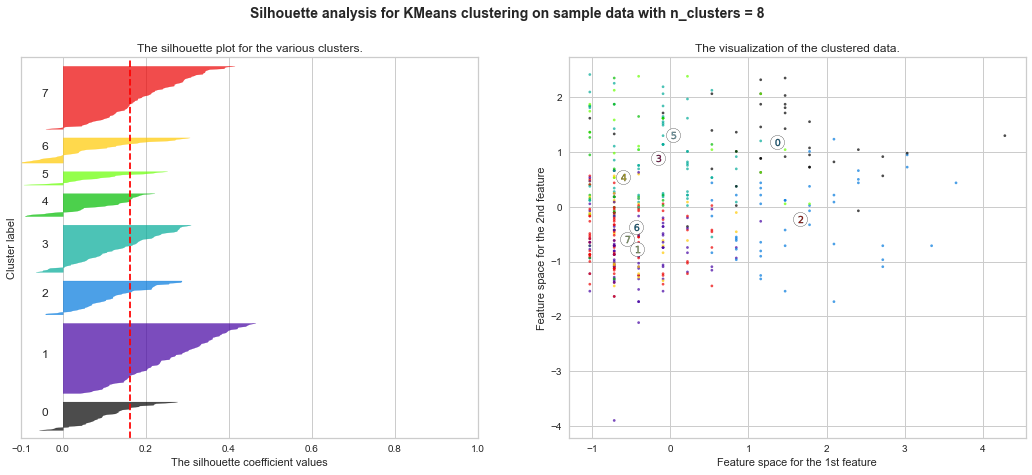

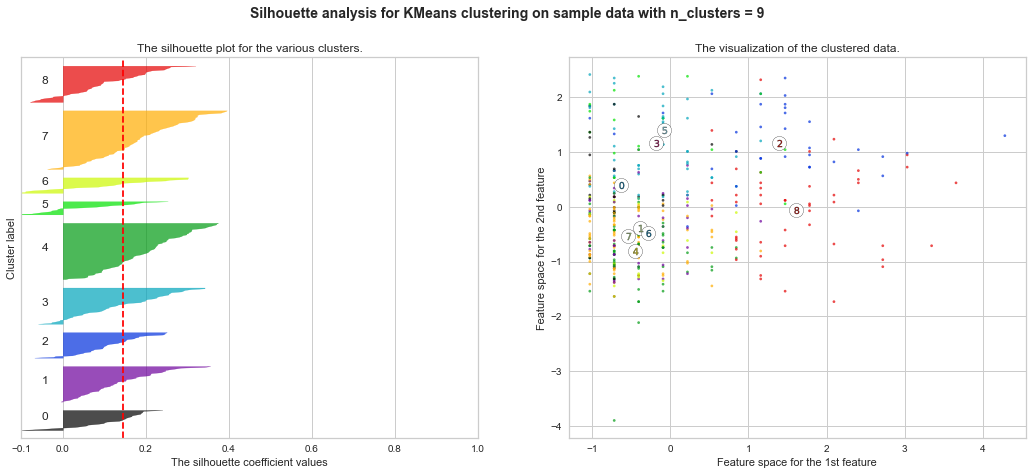

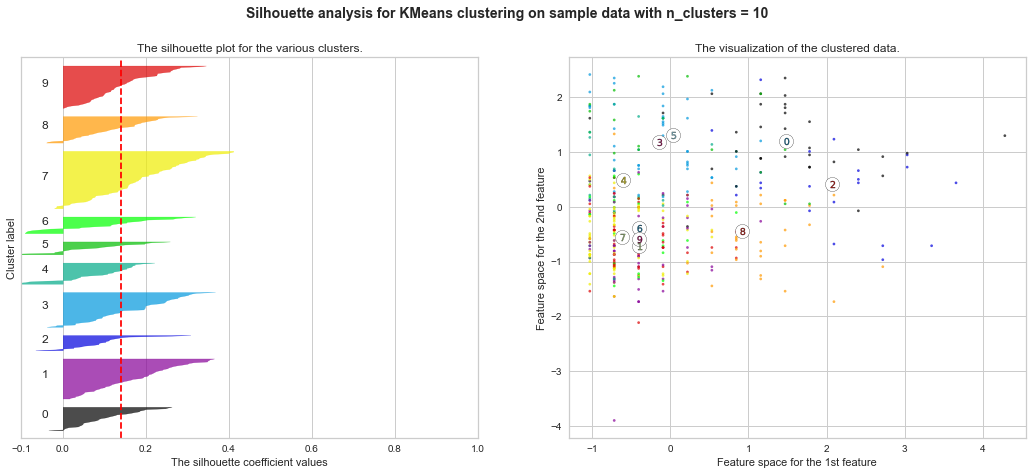

In [24]:
k_means_silhouette(X)

# GMM

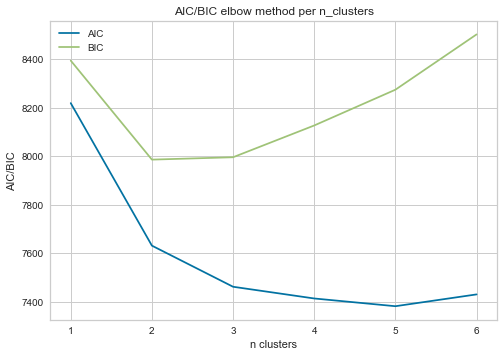

In [25]:
GMM_elbow(X, y)

# PCA

(394, 8)
(394, 8)


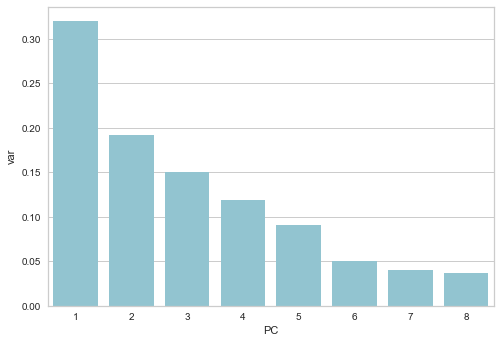

0.3198574538348917
yes
0.19137096198255407
yes
0.1506612693153406
yes
0.11931112160915672
yes
0.09095874607559704
yes
0.05050900391479219
0.040383200959764026
0.03694824230790369
(394, 8)
(394, 4)


<Figure size 576x396 with 0 Axes>

In [26]:
pca_X = pca_experiment(X, y, 8, 0.8)

# (X, y, n_components, variance_thresh, visualize=True):

# ICA

c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


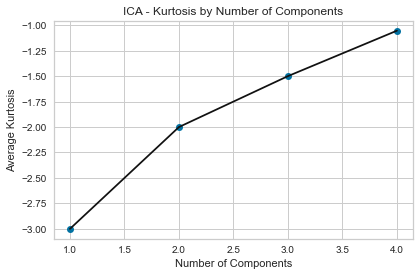

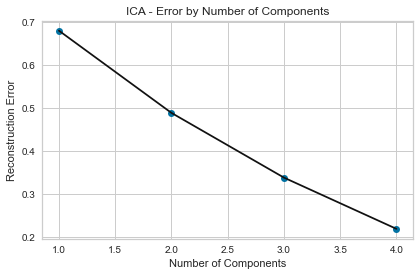

4


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


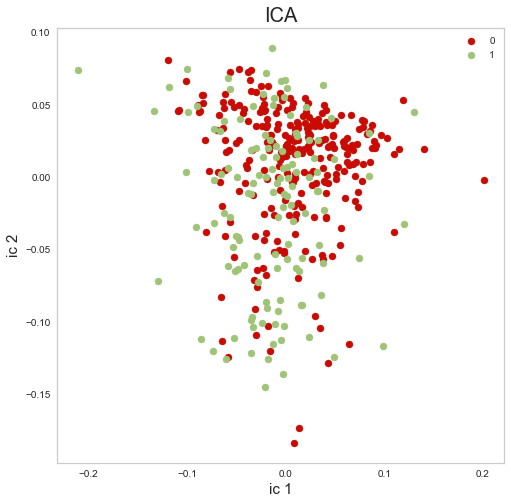

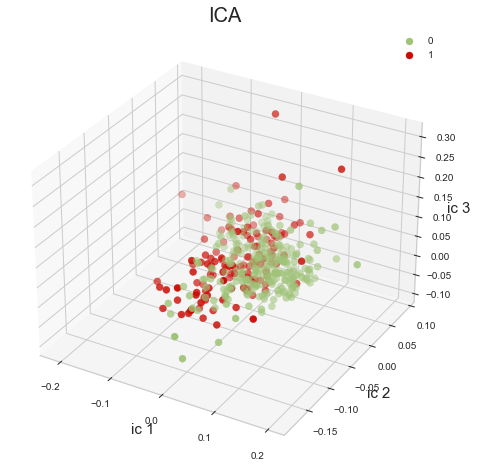

In [47]:
best_n_comp_val, best_kurt = analyze_ICA(X, 5)
print(best_n_comp_val)
ica_X = ica_experiment(X, best_n_comp_val)

# RP

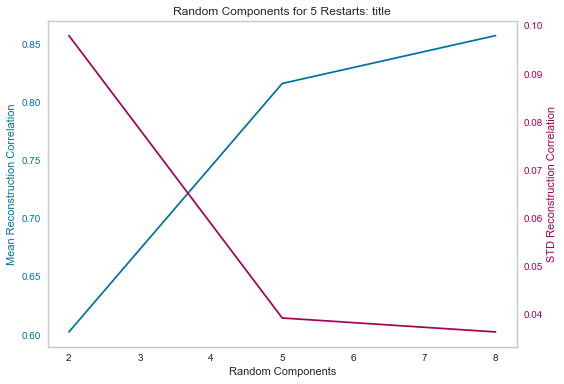

In [49]:
run_SparseRandomProjection(X,"title")
RP_X = RP_experiment(X, 5)

# RF

[[-0.71338621 -1.06211441 -0.37375871 ... -0.67887456 -1.02533958
  -0.96354812]
 [-1.02534421  0.46865131 -2.46142734 ...  1.4041682   5.04016543
   0.21453709]
 [-0.08947019 -1.41291488 -1.65847787 ... -0.27615296 -0.79370078
  -0.47267928]
 ...
 [-0.4014282  -1.09400536 -1.01611829 ... -0.63721371  0.68764368
  -0.86537435]
 [ 2.09423587 -0.67942298  0.42919076 ... -0.01230088 -1.01390063
   3.15975012]
 [ 0.53444583 -0.04160393  0.10801097 ... -0.94272665 -0.80227999
  -0.07998421]]
Pregnancies = 0.08209155606222784
Glucose = 0.24471048894458444
BloodPressure = 0.07231320376520889
SkinThickness = 0.08414883587717652
Insulin = 0.15307175981496254
BMI = 0.11815376747086946
DiabetesPedigreeFunction = 0.10779988897832923
Age = 0.13771049908664112
[('Pregnancies', 0.08209155606222784), ('Glucose', 0.24471048894458444), ('BloodPressure', 0.07231320376520889), ('SkinThickness', 0.08414883587717652), ('Insulin', 0.15307175981496254), ('BMI', 0.11815376747086946), ('DiabetesPedigreeFunction

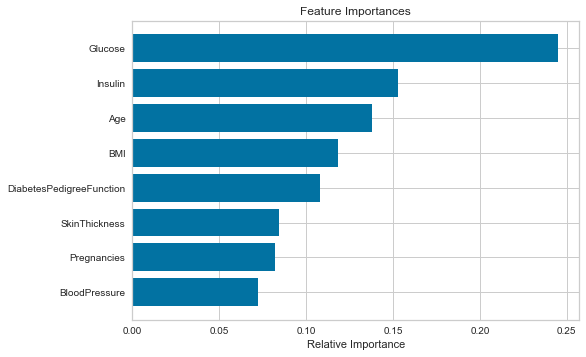

In [50]:
data_directory = "data/"
filename = "diabetes.csv"
df = pd.read_csv(data_directory + filename)
indices = range(0,len(df.columns[:-1]))
RFC_X = RFC_experiment(X, y, df.columns[:-1], x_indices=indices)

In [52]:
print(pca_X.shape)
print(ica_X.shape)
print(RP_X.shape)
print(RFC_X.shape)

(394, 4)
(394, 5)
(394, 5)
(394, 6)


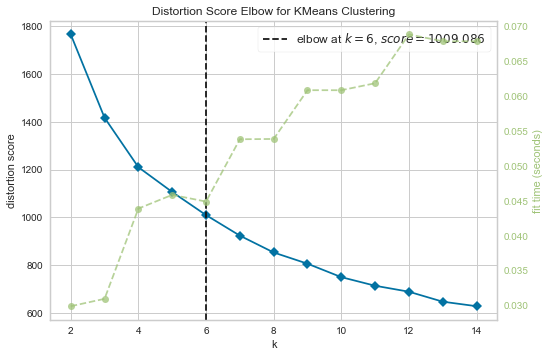

For n_clusters = 2 The average silhouette_score is : 0.295620470138481
For n_clusters = 3 The average silhouette_score is : 0.27468387446130815
For n_clusters = 4 The average silhouette_score is : 0.2695360713443024
For n_clusters = 5 The average silhouette_score is : 0.20381639907129048
For n_clusters = 6 The average silhouette_score is : 0.22808999062843066
For n_clusters = 7 The average silhouette_score is : 0.22903663572545646
For n_clusters = 8 The average silhouette_score is : 0.23389964258819124
For n_clusters = 9 The average silhouette_score is : 0.2290073246332789
For n_clusters = 10 The average silhouette_score is : 0.23517726215219756


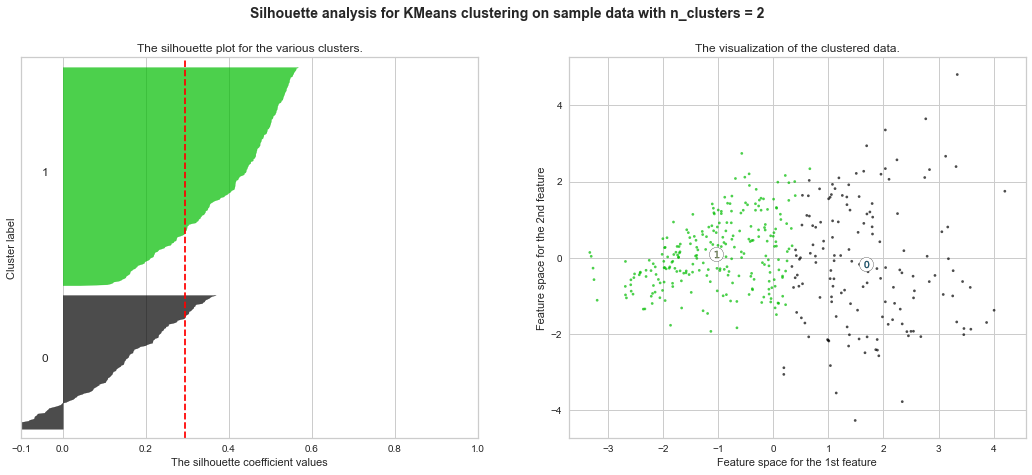

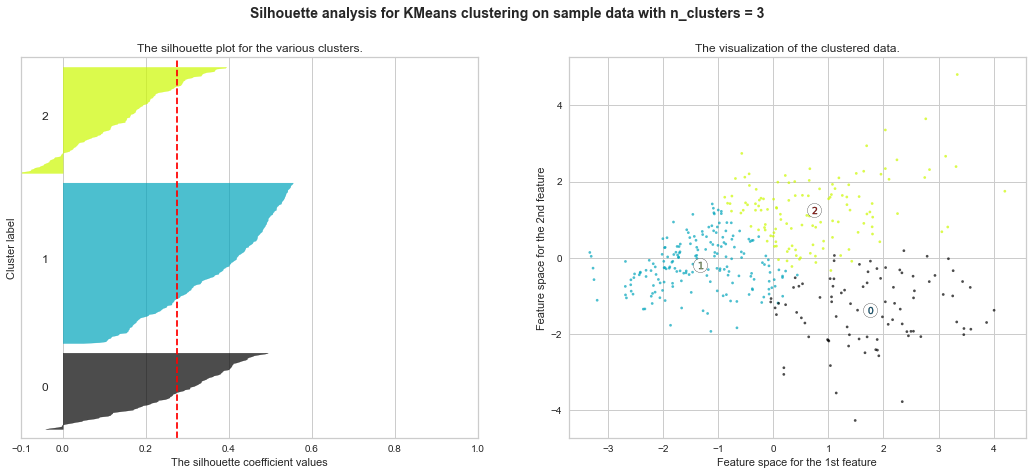

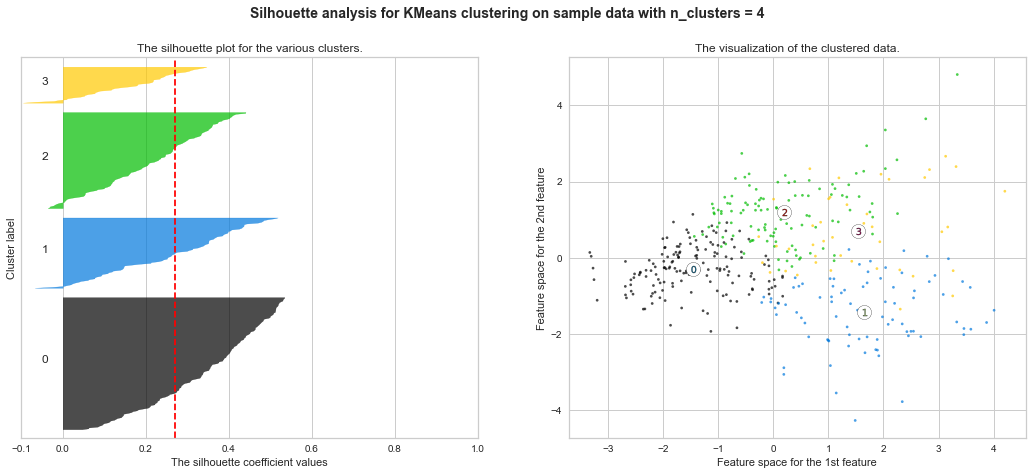

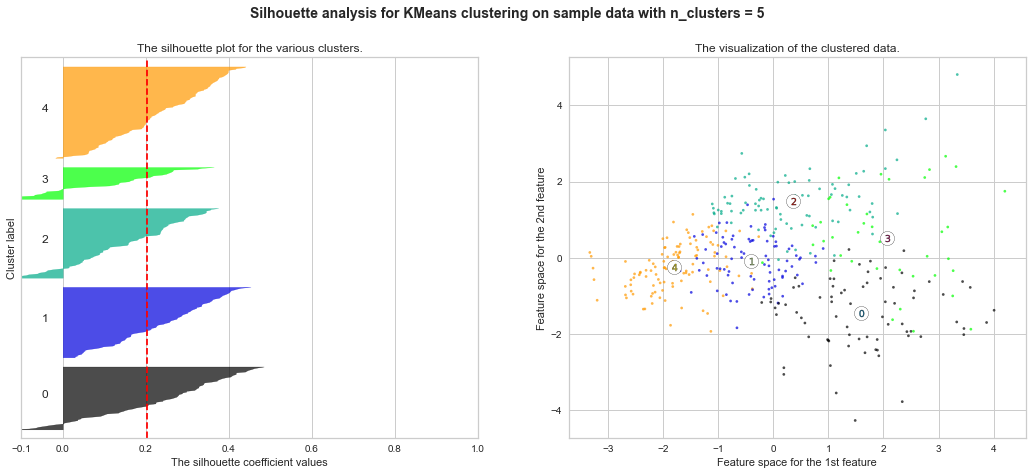

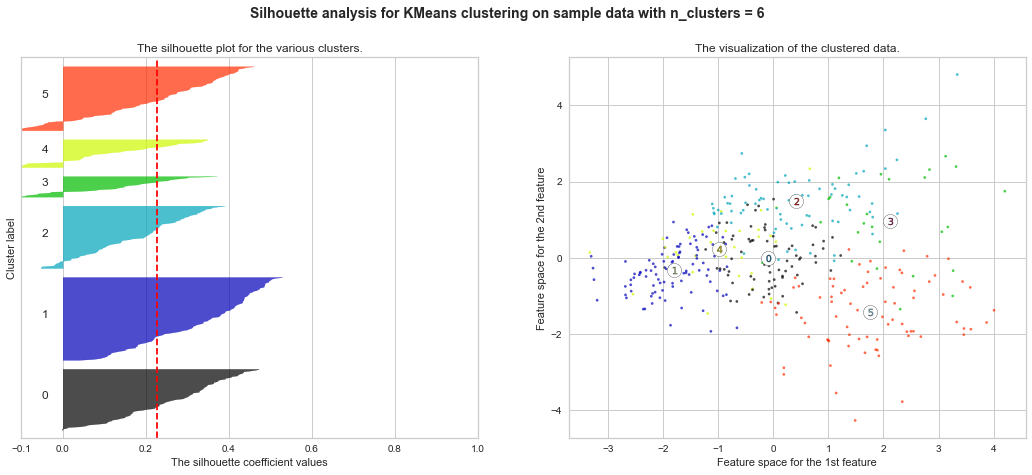

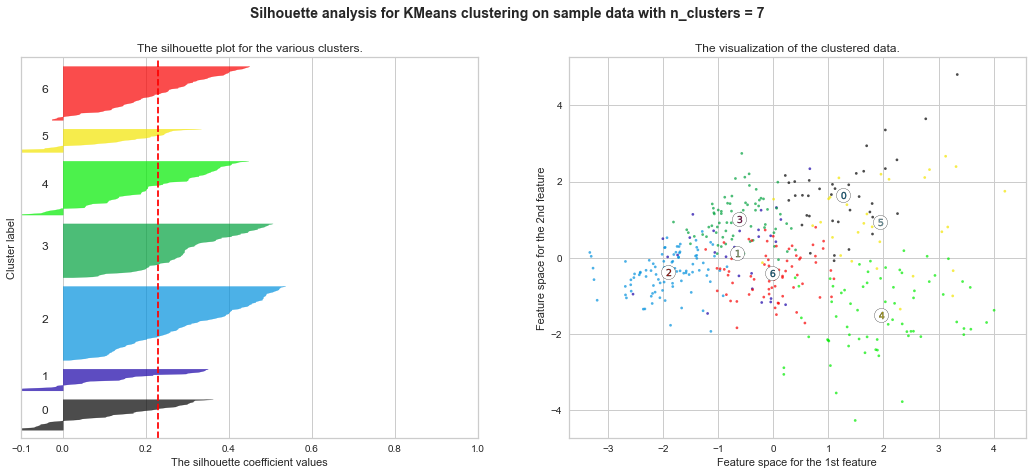

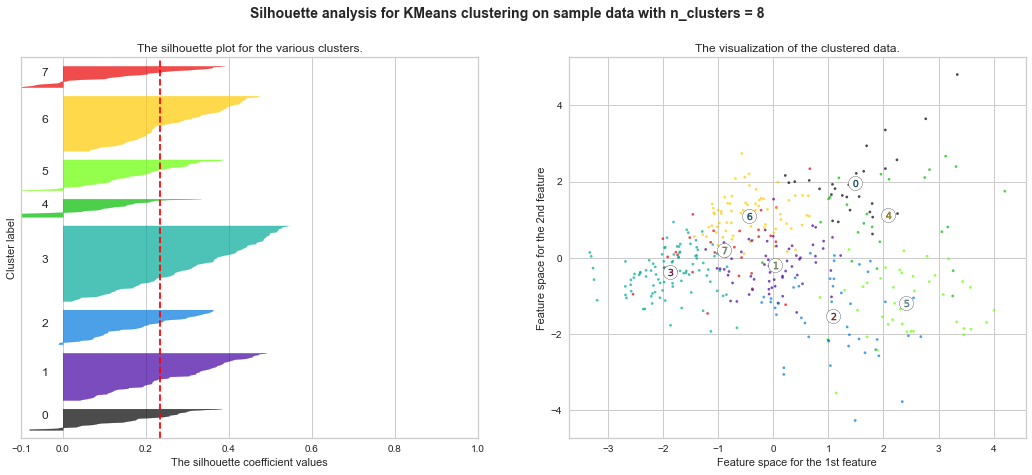

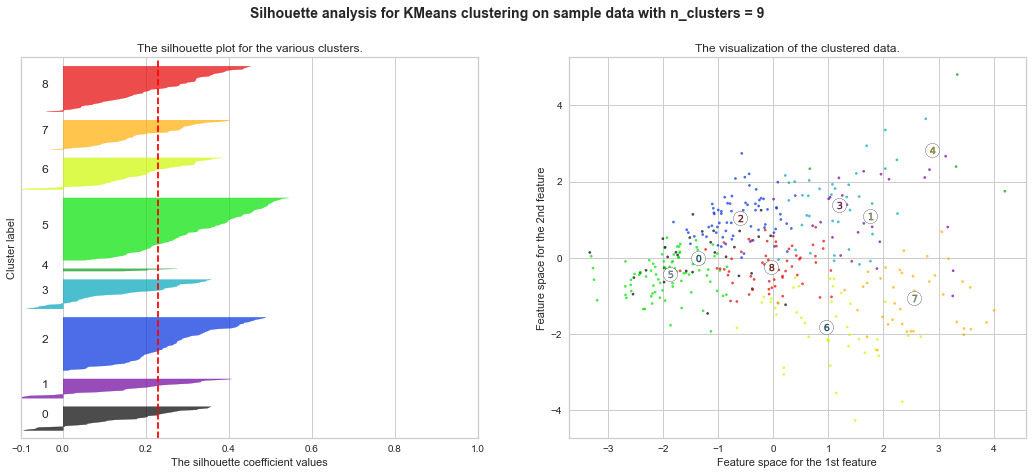

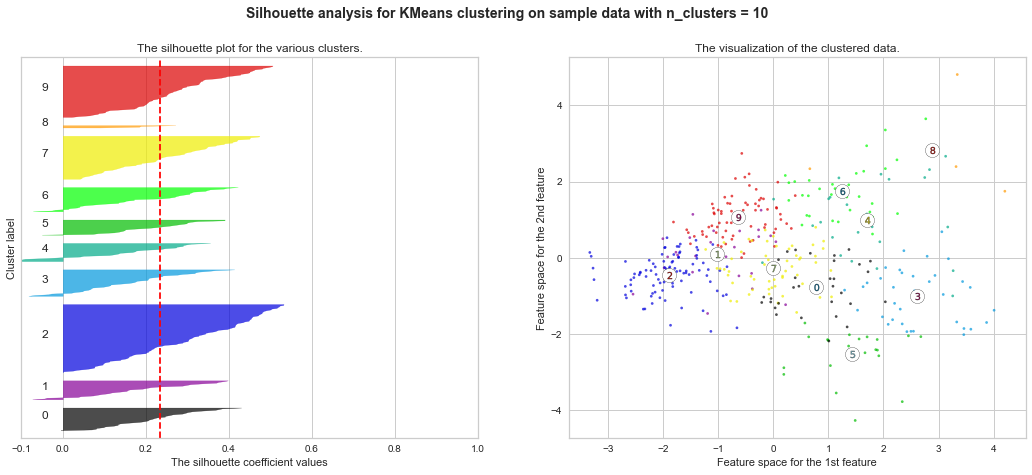

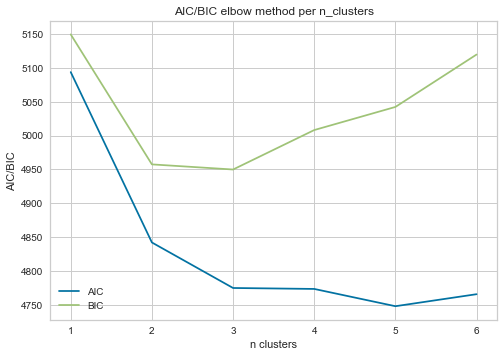

In [53]:
k_means_elbow_viz(pca_X)
k_means_silhouette(pca_X)
GMM_elbow(pca_X, y)


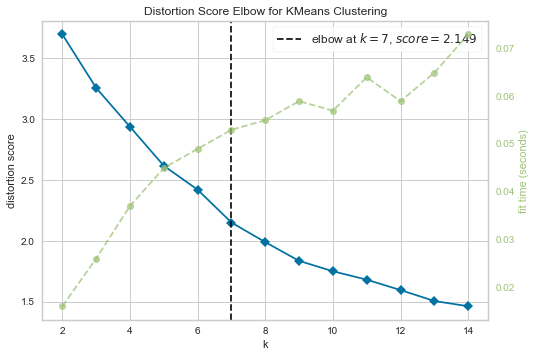

For n_clusters = 2 The average silhouette_score is : 0.8765851251182573


TypeError: '(slice(None, None, None), 0)' is an invalid key

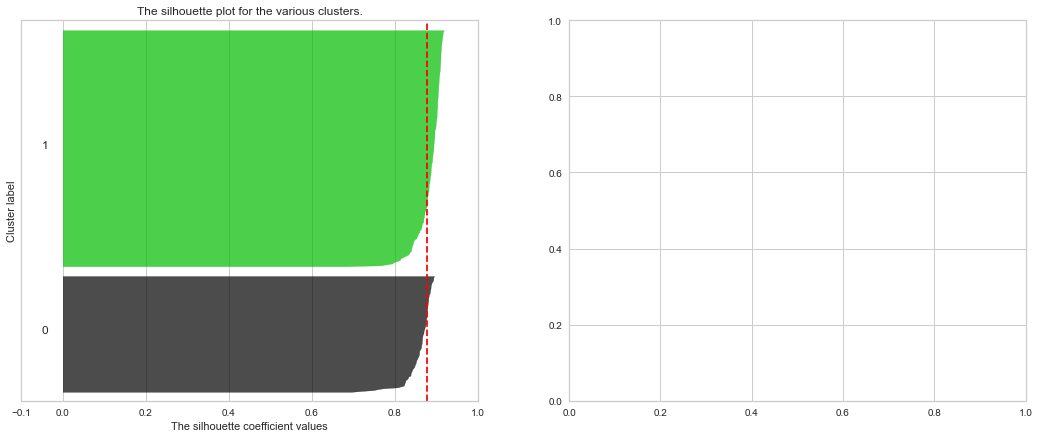

In [54]:
k_means_elbow_viz(ica_X)
k_means_silhouette(ica_X)
GMM_elbow(ica_X, y)

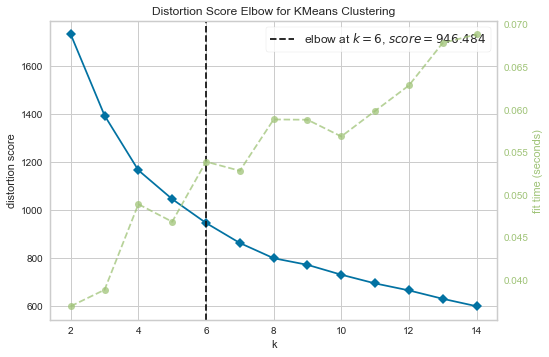

For n_clusters = 2 The average silhouette_score is : 0.2269314797137353
For n_clusters = 3 The average silhouette_score is : 0.24724066104655404
For n_clusters = 4 The average silhouette_score is : 0.2449923775157267
For n_clusters = 5 The average silhouette_score is : 0.20776798445230962
For n_clusters = 6 The average silhouette_score is : 0.21098327735440592
For n_clusters = 7 The average silhouette_score is : 0.21553771809585232
For n_clusters = 8 The average silhouette_score is : 0.2185085645508621
For n_clusters = 9 The average silhouette_score is : 0.21201424394773274
For n_clusters = 10 The average silhouette_score is : 0.19778447065705673


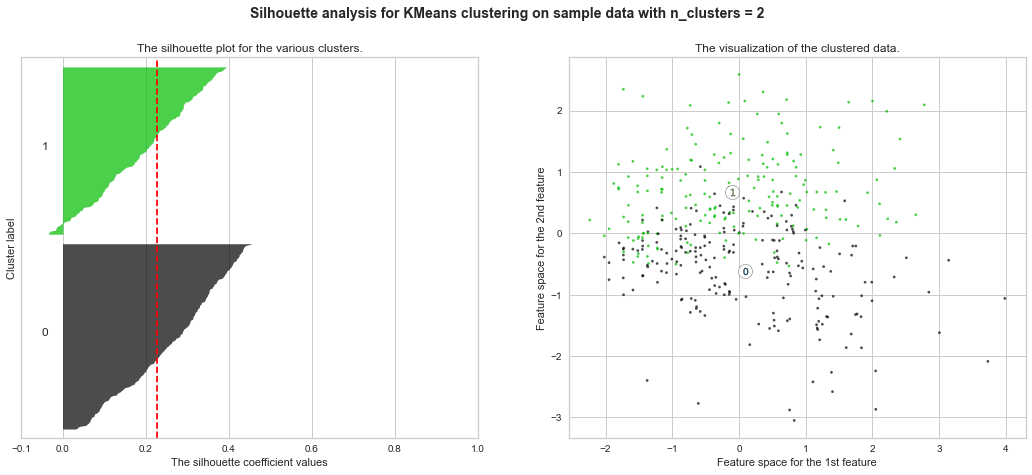

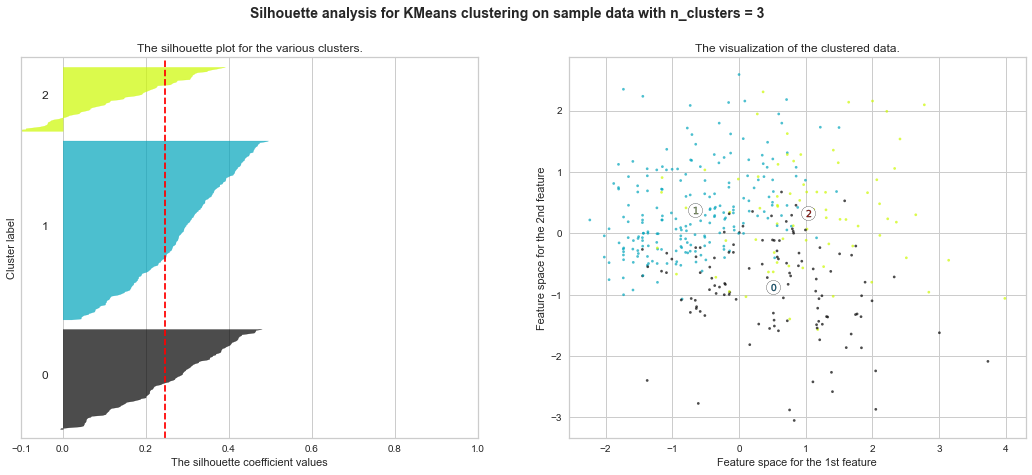

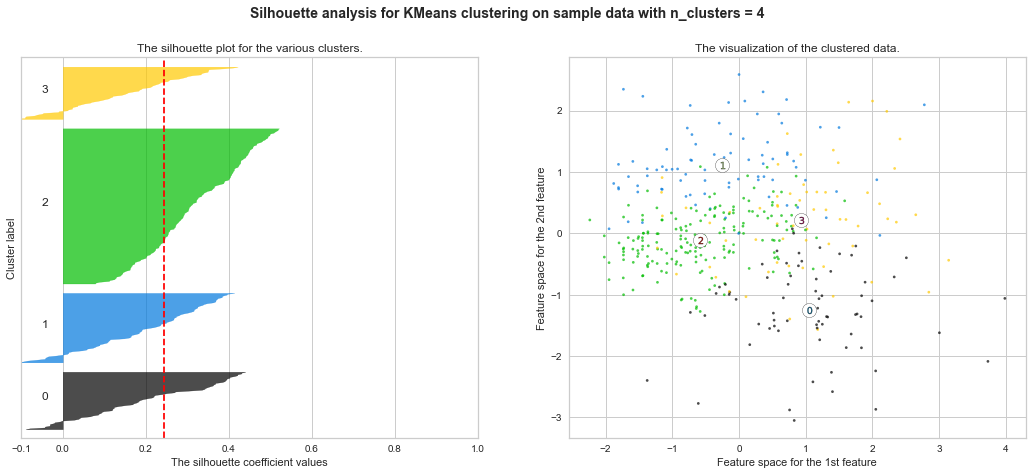

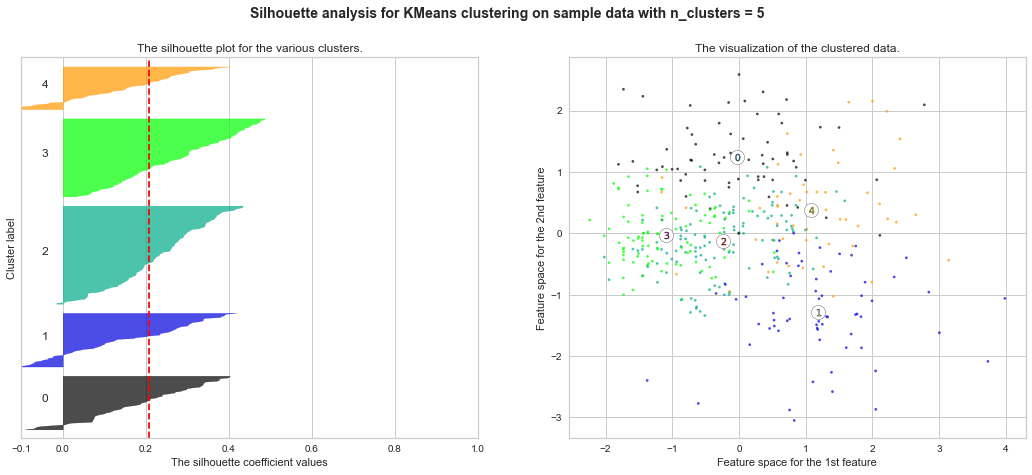

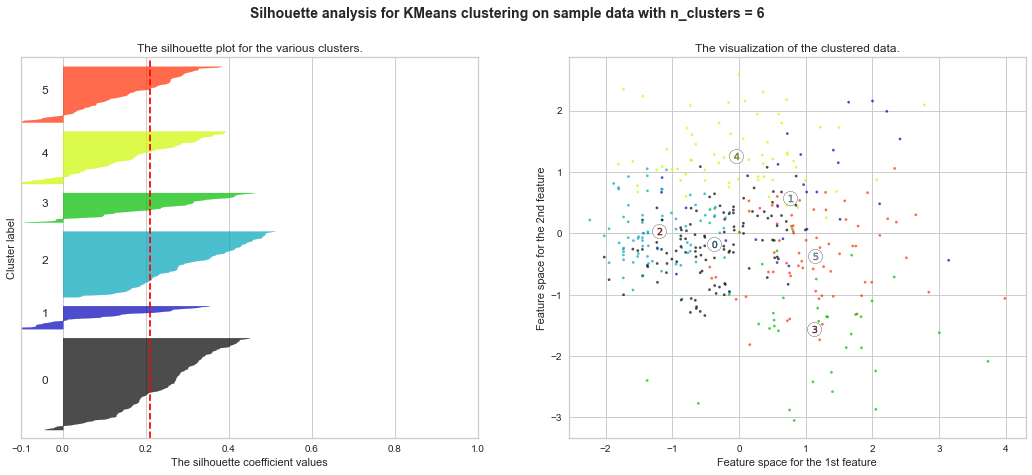

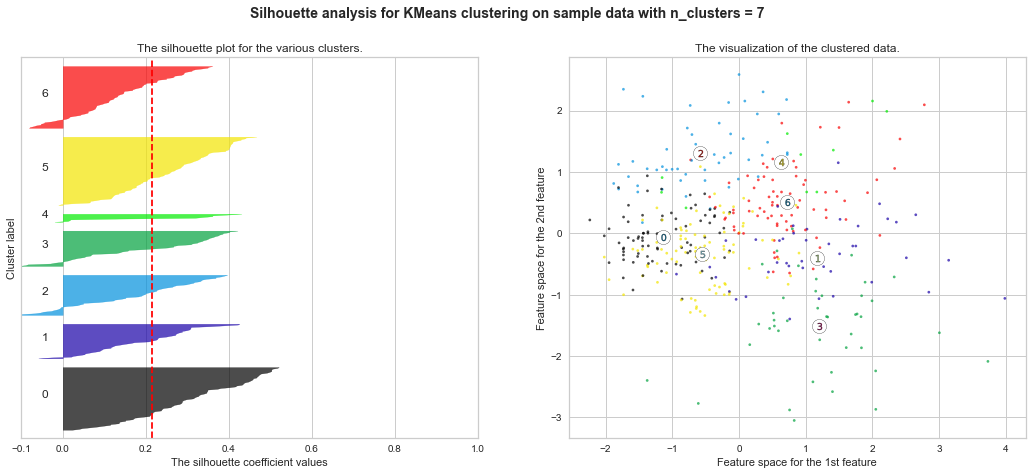

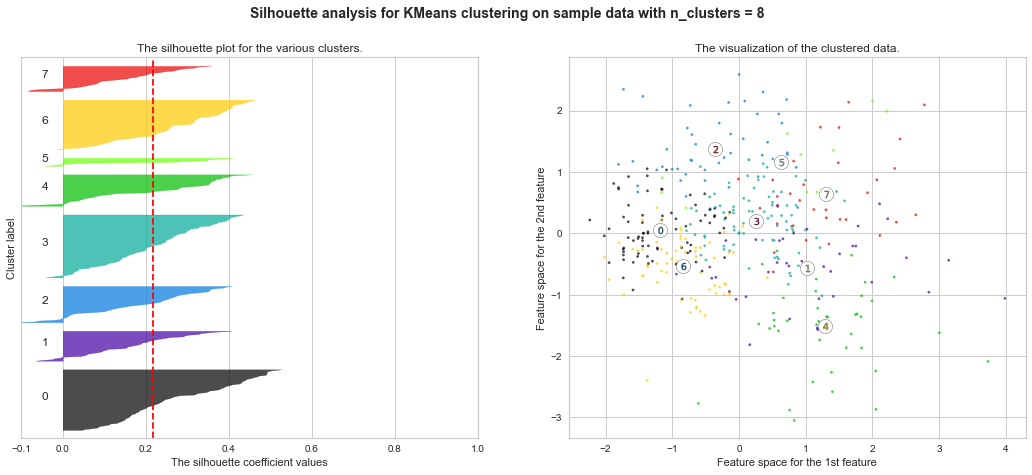

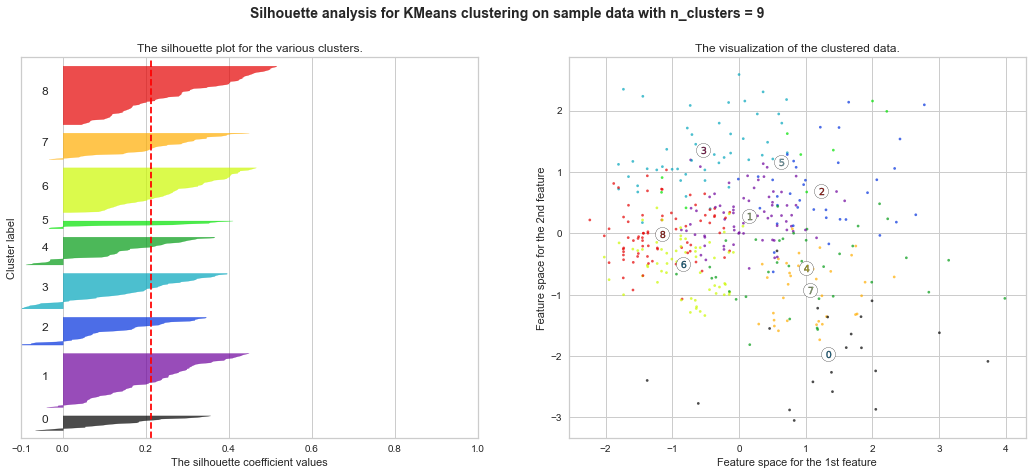

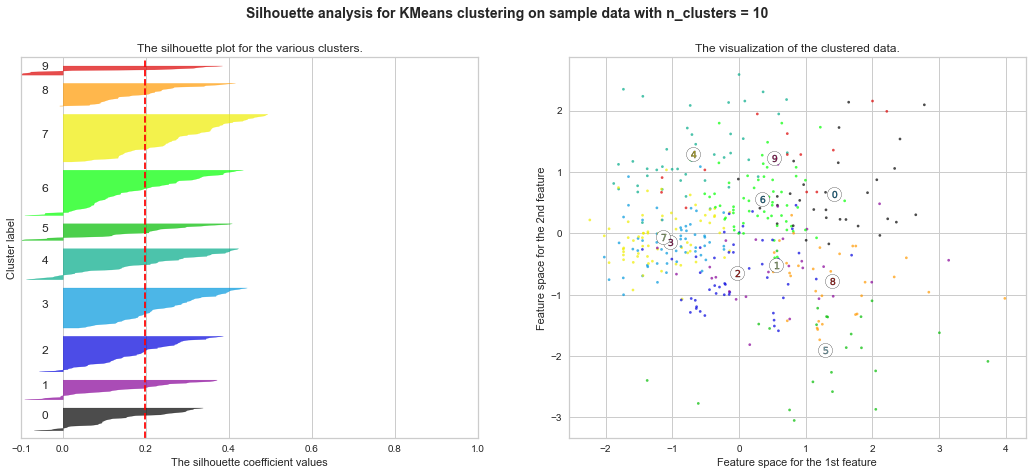

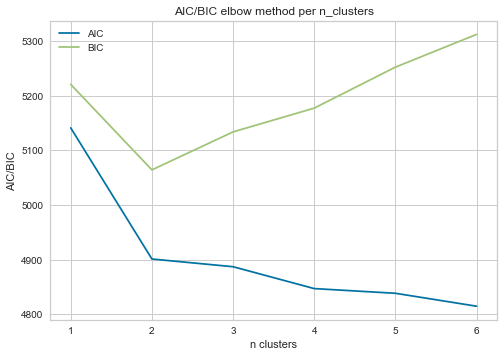

In [55]:
k_means_elbow_viz(RP_X)
k_means_silhouette(RP_X)
GMM_elbow(RP_X, y)

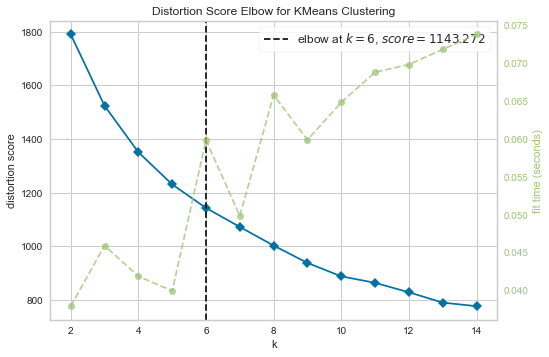

For n_clusters = 2 The average silhouette_score is : 0.23251696711349046
For n_clusters = 3 The average silhouette_score is : 0.21448460897338165
For n_clusters = 4 The average silhouette_score is : 0.23337731126163455
For n_clusters = 5 The average silhouette_score is : 0.2327629954387576
For n_clusters = 6 The average silhouette_score is : 0.1798627269391285
For n_clusters = 7 The average silhouette_score is : 0.166616400303527
For n_clusters = 8 The average silhouette_score is : 0.18781517074679877
For n_clusters = 9 The average silhouette_score is : 0.19248820208735604
For n_clusters = 10 The average silhouette_score is : 0.17589428911134036


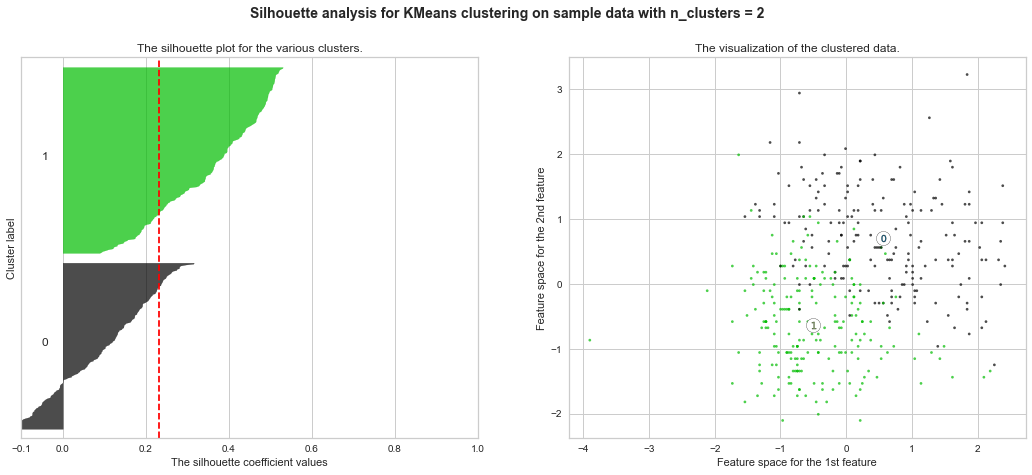

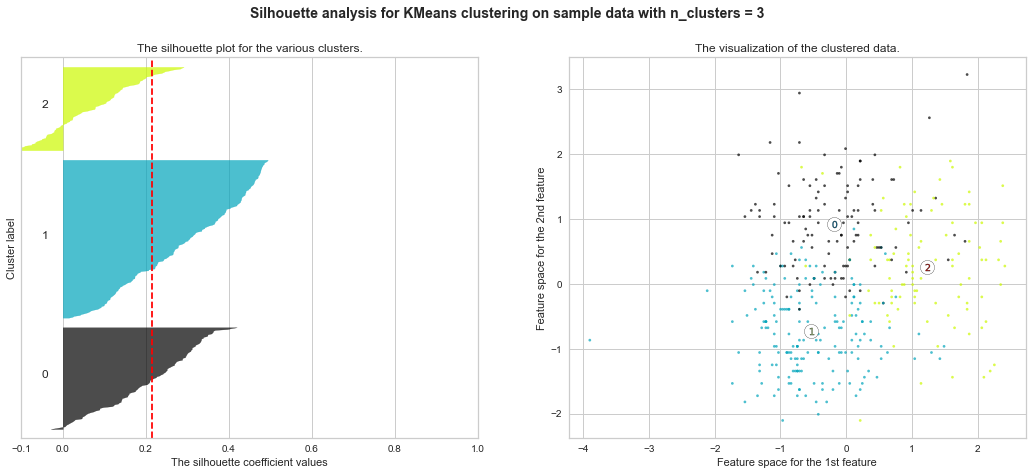

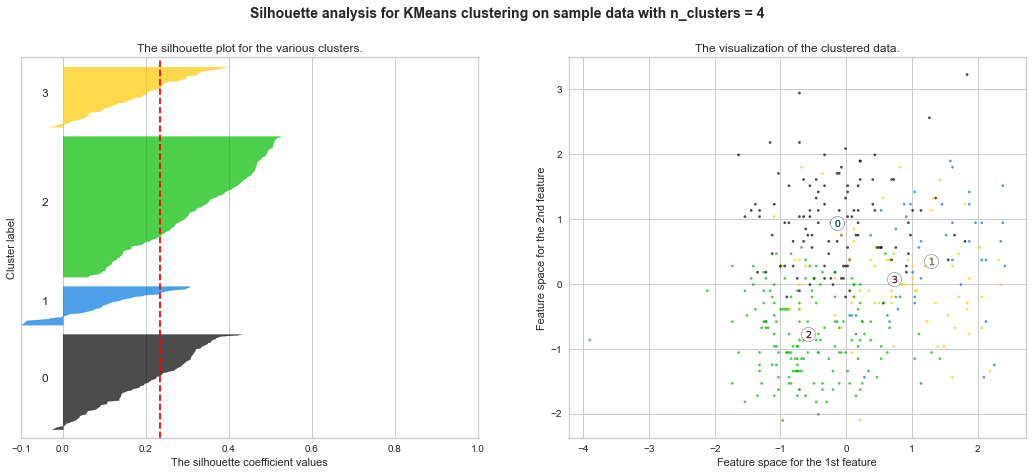

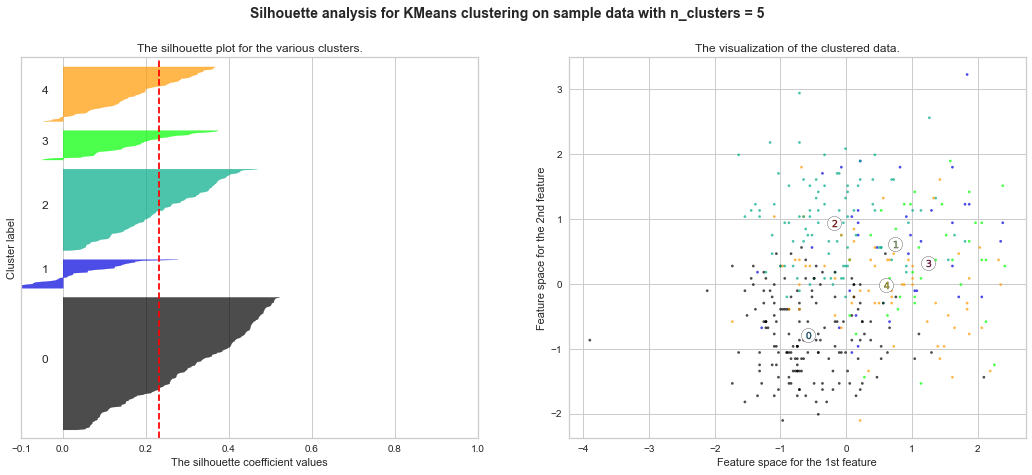

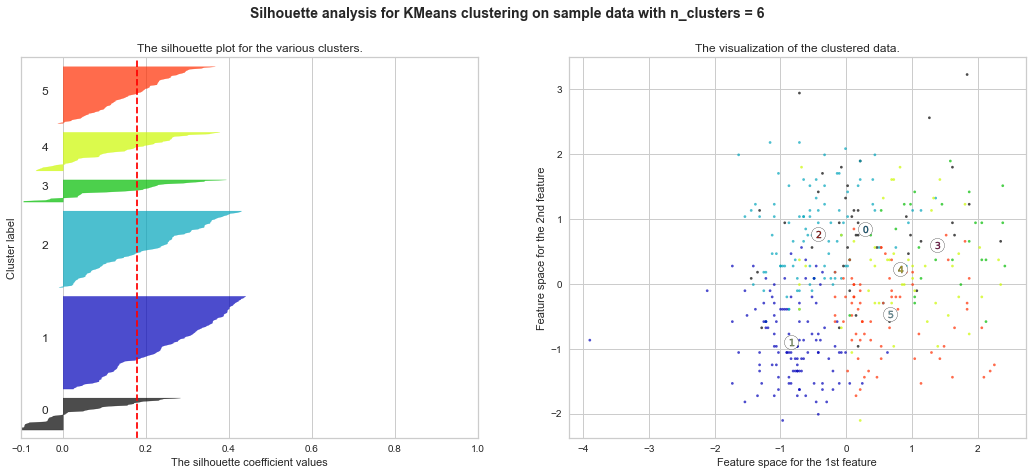

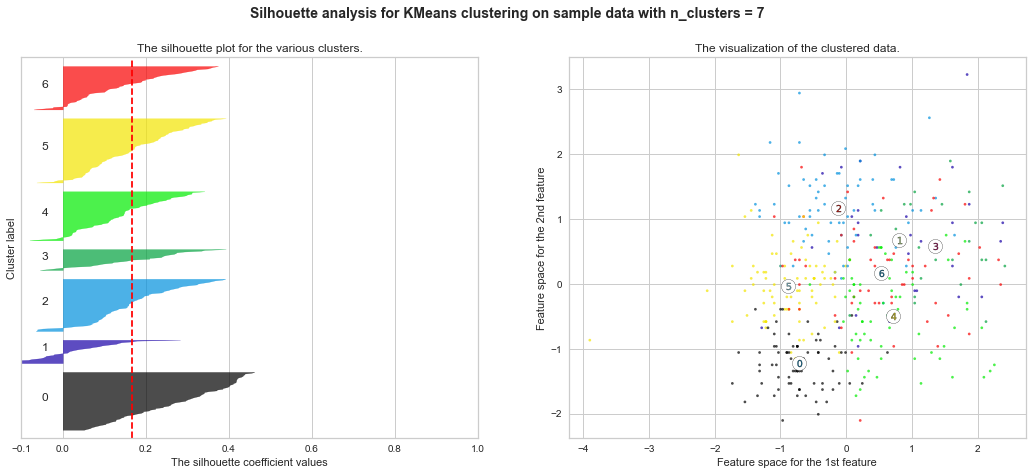

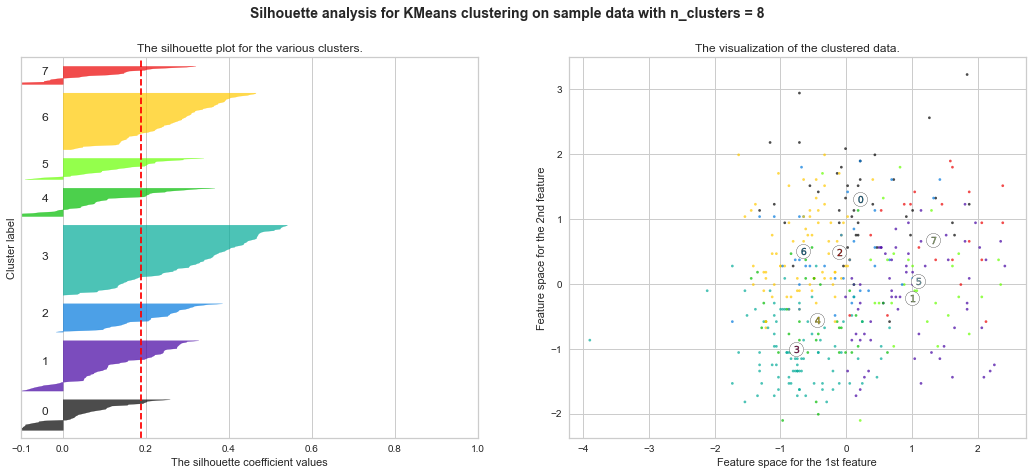

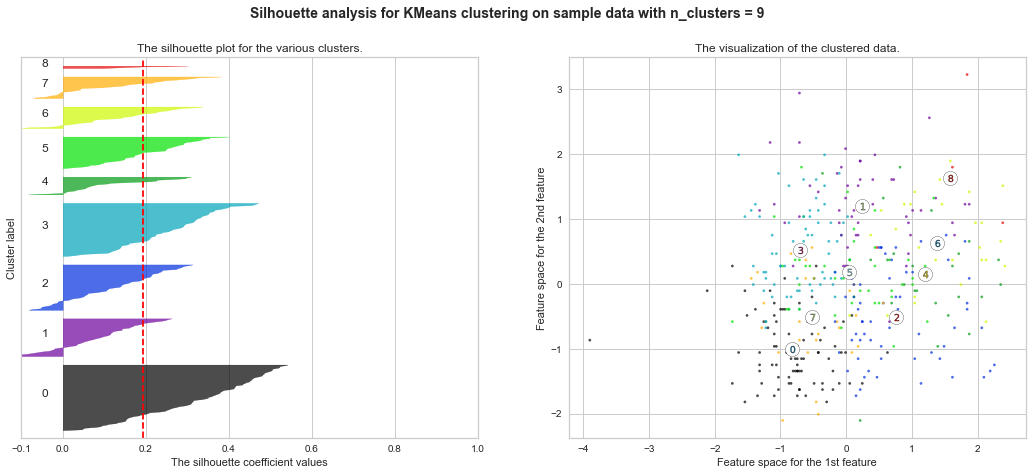

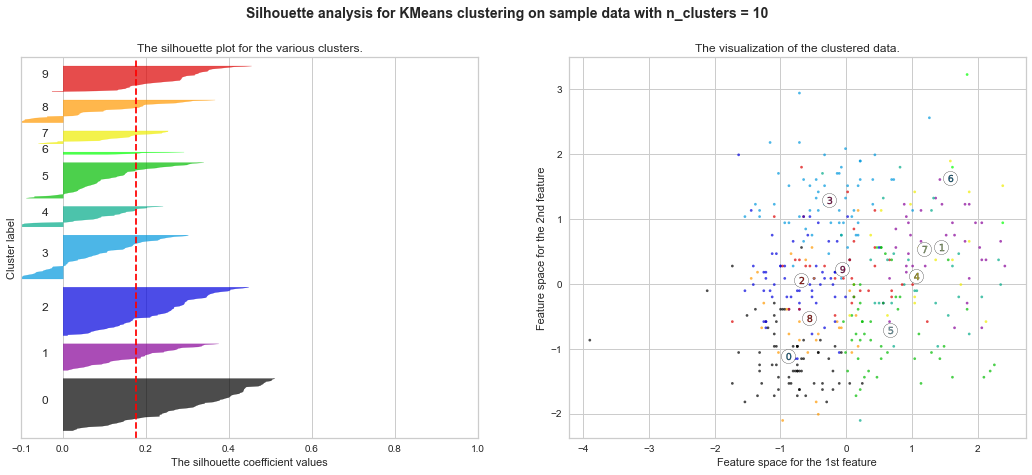

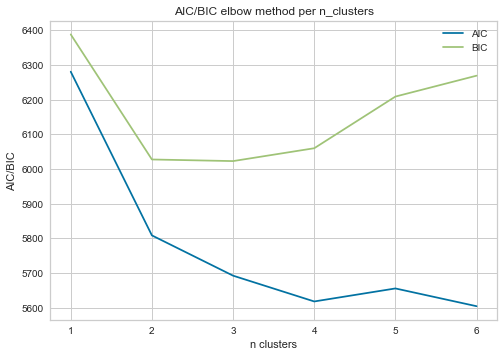

In [56]:
k_means_elbow_viz(RFC_X)
k_means_silhouette(RFC_X)
GMM_elbow(RFC_X, y)